In [1]:
import torch; torch.manual_seed(0)
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from function.VAE import VAE
from function.Dir import Dir

BATCH_SIZE = 32
EPOCHS = 5
LATENTDIM = 256
DEVICE = torch.device("cuda")
model = f'{Dir.models()}/model_{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn.pth'

In [2]:
with torch.no_grad(): # 不要输出
    vae = VAE(LATENTDIM).to(DEVICE)
    vae = nn.DataParallel(vae) # 并行运算带来的修饰vae的代码
    vae.load_state_dict(torch.load(model, map_location=DEVICE)) 
    vae.eval()

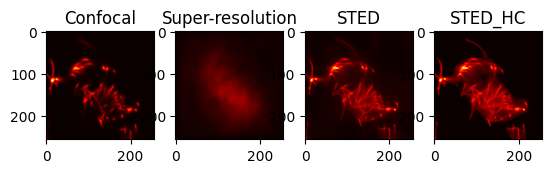

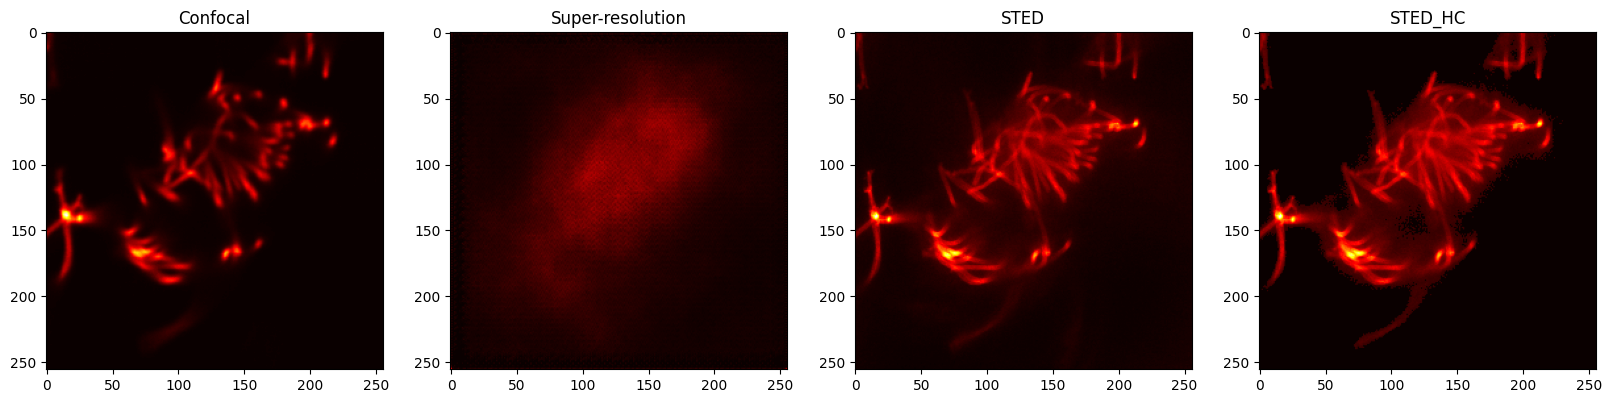

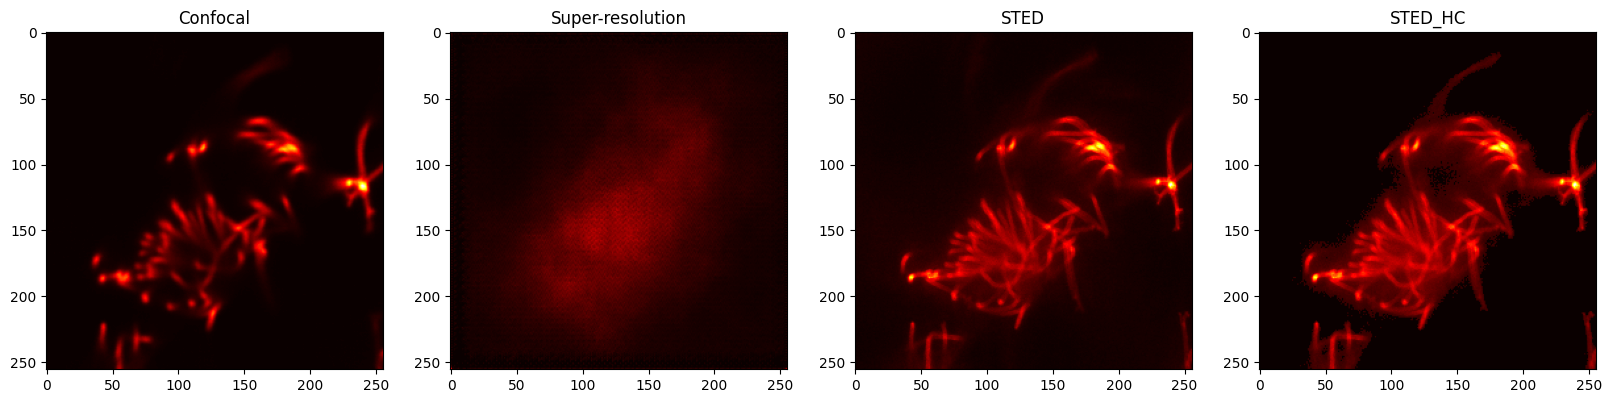

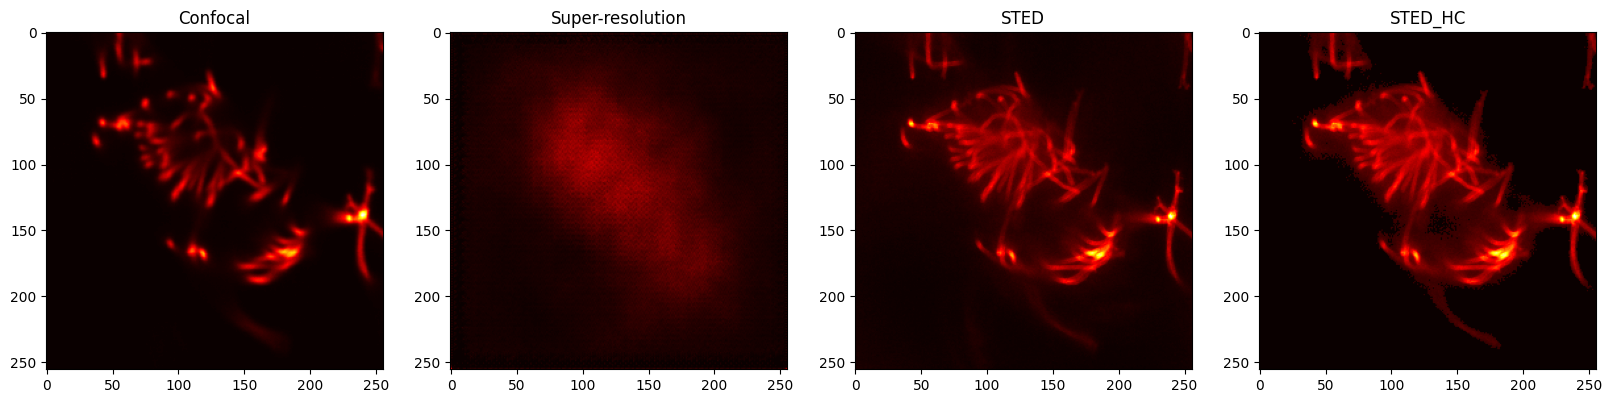

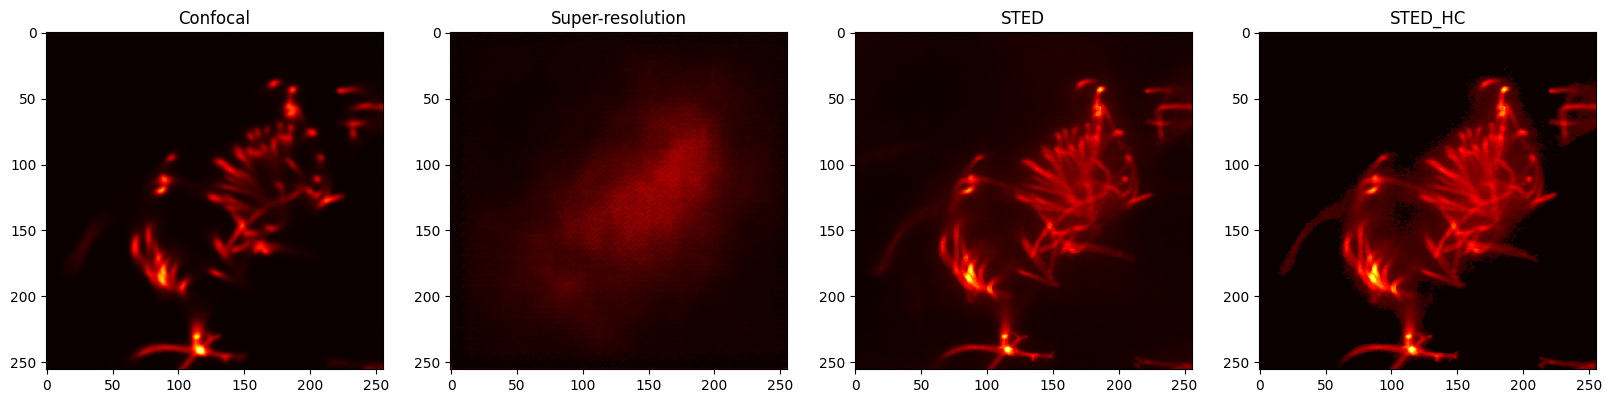

In [3]:
first_fig_num = 2000
iteration_times = 1
do_save = 0
for i in range(first_fig_num,first_fig_num+5):
    img_Confocal, img_STED, img_STED_HC = Image.open(f"{Dir.Confocal()}/{i}_Confocal.png"), Image.open(f"{Dir.STED()}/{i}_STED.png") ,Image.open(f"{Dir.STED_HC()}/{i}_STED_HC.png")
    preprocess = transforms.Compose([transforms.ToTensor()])
    img_tobe_iterated = img_Confocal
    for j in range(iteration_times): # 迭代
        img_tobe_iterated= preprocess(img_tobe_iterated)
        img_tobe_iterated = img_tobe_iterated.unsqueeze(0).to(DEVICE)  # 添加批次维度，变为 shape [1, C, H, W]
        with torch.no_grad():
            img_tobe_iterated = vae(img_tobe_iterated)
        img_tobe_iterated = img_tobe_iterated[0][0].squeeze(0)
        img_tobe_iterated = img_tobe_iterated.to('cpu')
        img_tobe_iterated = img_tobe_iterated.numpy()
        img_tobe_iterated = (img_tobe_iterated - img_tobe_iterated.min()) / (img_tobe_iterated.max() - img_tobe_iterated.min()) * 255.0
        img_tobe_iterated = img_tobe_iterated.astype(np.uint8)
        img_tobe_iterated = Image.fromarray(img_tobe_iterated)
    img_SR = img_tobe_iterated

    fig,ax = plt.subplots(1,4)
    plt.rcParams['figure.figsize'] = [20, 10]
    ax[0].imshow(img_Confocal,cmap='hot')
    ax[0].set_title('Confocal')
    ax[1].imshow(img_SR,cmap='hot')
    ax[1].set_title('Super-resolution')
    ax[2].imshow(img_STED,cmap='hot')
    ax[2].set_title('STED')
    ax[3].imshow(img_STED_HC,cmap='hot')
    ax[3].set_title('STED_HC')
    #plt.savefig('1.png')
    plt.show()
    if do_save == 1:
        img_Confocal.save(f'{Dir.imgs()}/{i}_Confocal.png')
        img_SR.save(f'{Dir.imgs()}/{i}_SR.png')
        img_STED.save(f'{Dir.imgs()}/{i}_STED.png')
        img_STED_HC.save(f'{Dir.imgs()}/{i}_STED_HC.png')